In [5]:
"""
We will start by implementing the experiments conducted by Albert, Jeong, and Barabasi.
"""

'\nWe will start by implementing the experiments conducted by Albert, Jeong, and Barabasi.\n'

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

### Creating an ER Random Graph and a WS Small World Graph

In [7]:
n = 10000
m = 20000
k = 4
# p_ER = 0.01
p_WS = 0.2

ER = nx.gnm_random_graph(n, m)
# ER = nx.erdos_renyi_graph(n, p_ER)
WS = nx.watts_strogatz_graph(n, k, p_WS)
print(ER, WS)

### Reading in the Electrical Grid Graph and Using that

In [8]:
def read_graph(filename):
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G

In [9]:
electrical_grid = read_graph('opsahl-powergrid/out.opsahl-powergrid')
print(electrical_grid)

In [10]:
import random
def flip(p):
    """Returns True with probability `p`."""
    return np.random.random() < p

# def random_attack(G, p):
#     """Returns a graph with nodes removed at probability p"""
#     H = G.copy()
#     for i in list(H.nodes()):
#         if flip(p):
#             H.remove_node(i)
#     return H

def random_attack(G, k):
    """Returns a graph with percent f nodes removed at random"""
    nodes_removed = random.sample(list(G.nodes),k=k)
    G.remove_nodes_from(nodes_removed)

def sample_path_lengths(G, nodes=None, trials=1000):
    """Choose random pairs of nodes and compute the path length between them.

    G: Graph
    nodes: list of nodes to choose from
    trials: number of pairs to choose

    returns: list of path lengths
    """
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)
    
        
    pairs = np.random.choice(nodes, (trials, 2))
    lengths = []
    for pair in pairs:
        try:
            path = nx.shortest_path_length(G, *pair)
            lengths.append(path)
        except:
            pass
    return lengths

def average_shortest_length(G):
    return np.mean(sample_path_lengths(G))

def cluster_size(G):
    
    clusters = []
    for i in list(G.nodes()):
        connected_nodes = nx.node_connected_component(G, i)
        clusters.append(len(connected_nodes))
    
    return set(clusters)

def largest_cluster(G):
    return max(cluster_size(G)) / len(G.nodes())

average shortest length:  4.067
cluster sizes:  {100}
largest relative cluster:  1.0


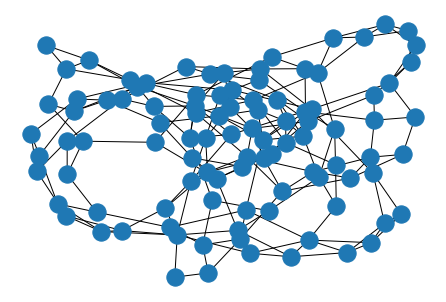

In [11]:
WS = nx.watts_strogatz_graph(100, 4, p_WS)
nx.draw(WS)

print("average shortest length: ", average_shortest_length(WS))
print("cluster sizes: ", cluster_size(WS))
print("largest relative cluster: ", largest_cluster(WS))

average shortest len:  4.141
cluster sizes:  {90}
largest relative cluster:  1.0
number of nodes:  90


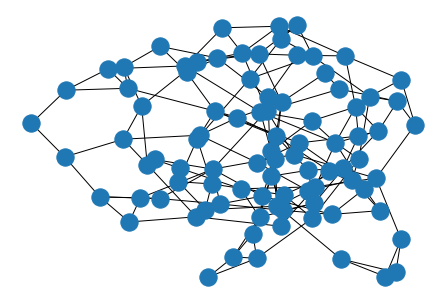

In [12]:
random_attack(WS, 10)
nx.draw(WS)
print("average shortest len: ", average_shortest_length(WS))
print("cluster sizes: ", cluster_size(WS))
print("largest relative cluster: ", largest_cluster(WS))
print("number of nodes: ", len(WS.nodes()))

In [13]:
n = 1000
m = 2000
k = 4
# p_ER = 0.01
p_WS = 0.2
step=.02
size = int(.8/step)
fr = np.linspace(1,size,size)*step

In [ ]:
er_cluster = []
ws_cluster = []

ER = nx.gnm_random_graph(n, m)
WS = nx.watts_strogatz_graph(n, k, p_WS)


for i in range(size):
    
    
    #remove nodes
    random_attack(ER, int(step*n))
    random_attack(WS, int(step*n))
#     print(len(ER.nodes()), len(WS.nodes()))
    
    #add largest relative cluster
    er_cluster.append(largest_cluster(ER))
    ws_cluster.append(largest_cluster(WS))

In [ ]:
plt.plot(fr, er_cluster)
plt.plot(fr, ws_cluster)
plt.legend(['er', 'ws'])
plt.xlabel("Fraction of Nodes Removed")
plt.ylabel("Relative largest Cluster")
plt.title("Robustness to Random Attacks")